# Example 3: Normalize data to MNI template

This example covers the normalization of data. Some people prefer to normalize the data during the preprocessing, just before smoothing. I prefer to do the 1st-level analysis completely in subject space and only normalize the contrasts for the 2nd-level analysis.

For the current example, we will take the computed 1st-level contrasts from the previous experiment (again once done with fwhm=4mm and fwhm=8mm) and normalize them into MNI-space. To show two different approaches, we will do the normalization once with SPM and once with ANTs.

# Normalization with ANTs

The normalization with ANTs requires that you first compute the transformation matrix that would bring the anatomical images of each subject into template space. Depending on your system this might take a few hours per subject. To facilitate this step, the transformation matrix is already computed for the T1 images. However, this transformation is for the 1mm resolution, not the 2 mm resolution of the contrasts.

The data for it can be found under:

In [1]:
!ls /data/ds000114/derivatives/fmriprep/sub-0[12]/anat/*h5

/data/ds000114/derivatives/fmriprep/sub-01/anat/sub-01_t1w_space-mni152nlin2009casym_warp.h5
/data/ds000114/derivatives/fmriprep/sub-02/anat/sub-02_t1w_space-mni152nlin2009casym_warp.h5


And the script to compute those files can be found here:

**Now let's start with the ANTs normalization workflow!**

## Imports

First, we need to import all modules we later want to use.

In [2]:
from os.path import join as opj
from nipype.interfaces.ants import ApplyTransforms
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.fsl import Info

## Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [3]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['sub-01', 'sub-02']

# task name
task_name = "fingerfootlips"

# Smoothing widths used during preprocessing
fwhm = [4, 8]

# Template to normalize to
template = '/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

## Specify Nodes

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [4]:
# Apply Transformation - applies the normalization matrix to contrast images
apply2con = MapNode(ApplyTransforms(args='--float',
                                    input_image_type=3,
                                    interpolation='BSpline',
                                    invert_transform_flags=[False],
                                    num_threads=1,
                                    reference_image=template,
                                    terminal_output='file'),
                    name='apply2con', iterfield=['input_image'])

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [5]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'con': opj(output_dir, '1stLevel',
                        '{subject_id}/fwhm-{fwhm_id}', '???_00??.nii'),
             'transform': opj('/data/ds000114/derivatives/fmriprep/', '{subject_id}', 'anat',
                              '{subject_id}_t1w_space-mni152nlin2009casym_warp.h5')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', '')]
subjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
subjFolders += [('_apply2con%s/' % (i), '') for i in range(9)] # number of contrast used in 1stlevel an.
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [6]:
# Initiation of the ANTs normalization workflow
antsflow = Workflow(name='antsflow')
antsflow.base_dir = opj(experiment_dir, working_dir)

# Connect up the ANTs normalization components
antsflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                             ('fwhm_id', 'fwhm_id')]),
                  (selectfiles, apply2con, [('con', 'input_image'),
                                            ('transform', 'transforms')]),
                  (apply2con, datasink, [('output_image', 'norm_ants.@con')]),
                  ])

## Visualize the workflow

It always helps to visualize your workflow.

170731-11:12:57,251 workflow INFO:
	 Generated workflow graph: /output/workingdir/antsflow/graph.dot.png (graph2use=colored, simple_form=True).


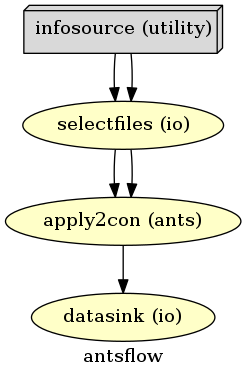

In [7]:
# Create ANTs normalization graph
antsflow.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(antsflow.base_dir, 'antsflow', 'graph.dot.png'))

##  Run the Workflow

Now that everything is ready, we can run the ANTs normalization workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [9]:
antsflow.run('MultiProc', plugin_args={'n_procs': 4})

170731-11:14:17,128 workflow INFO:
	 Workflow antsflow settings: ['check', 'execution', 'logging']
170731-11:14:17,204 workflow INFO:
	 Running in parallel.
170731-11:14:17,208 workflow INFO:
	 Executing: selectfiles.a3 ID: 0
170731-11:14:17,218 workflow INFO:
	 Executing: selectfiles.a2 ID: 3
170731-11:14:17,221 workflow INFO:
	 Executing node selectfiles.a3 in dir: /output/workingdir/antsflow/_fwhm_id_8_subject_id_sub-02/selectfiles
170731-11:14:17,229 workflow INFO:
	 Executing: selectfiles.a1 ID: 6
170731-11:14:17,238 workflow INFO:
	 Executing node selectfiles.a2 in dir: /output/workingdir/antsflow/_fwhm_id_4_subject_id_sub-02/selectfiles
170731-11:14:17,254 workflow INFO:
	 Executing: selectfiles.a0 ID: 9
170731-11:14:17,258 workflow INFO:
	 Executing node selectfiles.a1 in dir: /output/workingdir/antsflow/_fwhm_id_8_subject_id_sub-01/selectfiles
170731-11:14:17,285 workflow INFO:
	 Executing node selectfiles.a0 in dir: /output/workingdir/antsflow/_fwhm_id_4_subject_id_sub-01/sel

# Normalization with SPM12

The normalization with SPM12 is rather straight forward. The only thing we need to do is run the Normalize12 module. **So let's start!**

## Imports

First, we need to import all modules we later want to use.

In [10]:
from os.path import join as opj
from nipype.interfaces.spm import Normalize12
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.misc import Gunzip
from nipype.pipeline.engine import Workflow, Node

## Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [11]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['sub-01', 'sub-02']

# task name
task_name = "fingerfootlips"

# Smoothing withds used during preprocessing
fwhm = [4, 8]

template = '/opt/spm12/spm12_mcr/spm/spm12/tpm/TPM.nii'

## Specify Nodes

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [12]:
# Gunzip - unzip the anatomical image
gunzip = Node(Gunzip(), name="gunzip")

# Normalize - normalizes functional and structural images to the MNI template
normalize = Node(Normalize12(jobtype='estwrite',
                             tpm=template,
                             write_voxel_sizes=[2, 2, 2]),
                 name="normalize")

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [13]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'con': opj(output_dir, '1stLevel',
                        '{subject_id}/fwhm-{fwhm_id}', '???_00??.nii'),
             'anat': opj('/data/ds000114/derivatives', 'fmriprep', '{subject_id}', 
                         'anat', '{subject_id}_t1w_preproc.nii.gz')}

selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', '')]
subjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [14]:
# Specify Normalization-Workflow & Connect Nodes
spmflow = Workflow(name='spmflow')
spmflow.base_dir = opj(experiment_dir, working_dir)

# Connect up SPM normalization components
spmflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('fwhm_id', 'fwhm_id')]),
                 (selectfiles, normalize, [('con', 'apply_to_files')]),
                 (selectfiles, gunzip, [('anat', 'in_file')]),
                 (gunzip, normalize, [('out_file', 'image_to_align')]),
                 (normalize, datasink, [('normalized_files', 'norm_spm.@files'),
                                        ('normalized_image', 'norm_spm.@image'),
                                        ]),
                 ])

## Visualize the workflow

It always helps to visualize your workflow.

170731-11:18:41,48 workflow INFO:
	 Generated workflow graph: /output/workingdir/spmflow/graph.dot.png (graph2use=colored, simple_form=True).


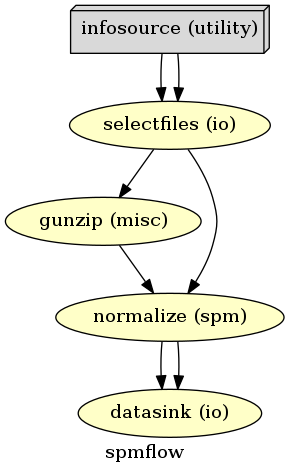

In [15]:
# Create SPM normalization graph
spmflow.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(spmflow.base_dir, 'spmflow', 'graph.dot.png'))

##  Run the Workflow

Now that everything is ready, we can run the SPM normalization workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [16]:
spmflow.run('MultiProc', plugin_args={'n_procs': 4})

170731-11:18:49,571 workflow INFO:
	 Workflow spmflow settings: ['check', 'execution', 'logging']
170731-11:18:49,676 workflow INFO:
	 Running in parallel.
170731-11:18:49,690 workflow INFO:
	 Executing: selectfiles.a3 ID: 0
170731-11:18:49,700 workflow INFO:
	 Executing: selectfiles.a2 ID: 4
170731-11:18:49,708 workflow INFO:
	 Executing: selectfiles.a1 ID: 8
170731-11:18:49,704 workflow INFO:
	 Executing node selectfiles.a3 in dir: /output/workingdir/spmflow/_fwhm_id_8_subject_id_sub-02/selectfiles170731-11:18:49,717 workflow INFO:
	 Executing: selectfiles.a0 ID: 12
170731-11:18:49,721 workflow INFO:
	 Executing node selectfiles.a1 in dir: /output/workingdir/spmflow/_fwhm_id_8_subject_id_sub-01/selectfiles

170731-11:18:49,710 workflow INFO:
	 Executing node selectfiles.a2 in dir: /output/workingdir/spmflow/_fwhm_id_4_subject_id_sub-02/selectfiles
170731-11:18:49,733 workflow INFO:
	 Executing node selectfiles.a0 in dir: /output/workingdir/spmflow/_fwhm_id_4_subject_id_sub-01/selectf

# Comparison between ANTs and SPM normalization

Now that we ran the normalization with ANTs and SPM, let us compare their output.

In [17]:
%pylab inline
from nilearn.plotting import plot_stat_map
anatimg = '/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

Populating the interactive namespace from numpy and matplotlib


/opt/conda/envs/neuro/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


First, let's compare the normalization of the **anatomical** images:

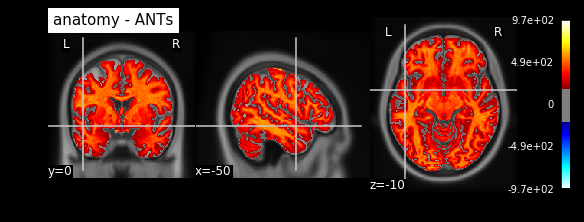

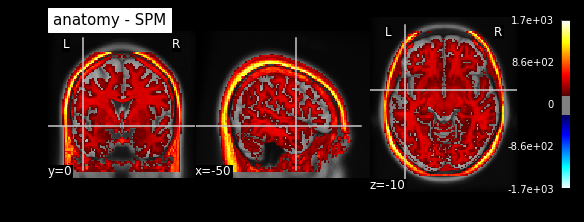

In [19]:
plot_stat_map(
    '/data/ds000114/derivatives/fmriprep/sub-01/anat/sub-01_t1w_space-mni152nlin2009casym_preproc.nii.gz', title='anatomy - ANTs',
    bg_img=anatimg, threshold=200, display_mode='ortho', cut_coords=(-50, 0, -10))
plot_stat_map(
    '/output/datasink/norm_spm/sub-01_fwhm4/wsub-01_t1w_preproc.nii', title='anatomy - SPM',
    bg_img=anatimg, threshold=200, display_mode='ortho', cut_coords=(-50, 0, -10))

And what about the **contrast** images?

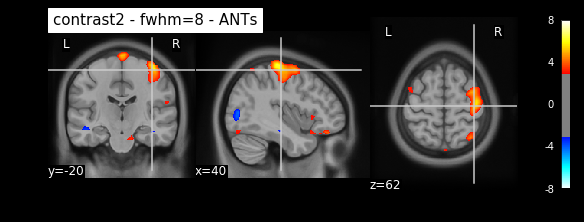

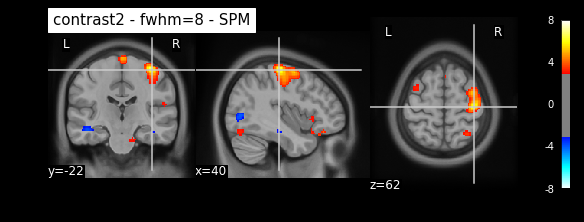

In [20]:
plot_stat_map(
    '/output/datasink/norm_ants/sub-01_fwhm8/con_0002_trans.nii', title='contrast2 - fwhm=8 - ANTs',
    bg_img=anatimg, threshold=3, display_mode='ortho', cut_coords=(40, -20, 62), vmax=8)
plot_stat_map(
    '/output/datasink/norm_spm/sub-01_fwhm8/wcon_0002.nii', title='contrast2 - fwhm=8 - SPM',
    bg_img=anatimg, threshold=3, display_mode='ortho', cut_coords=(40, -22, 62), vmax=8)

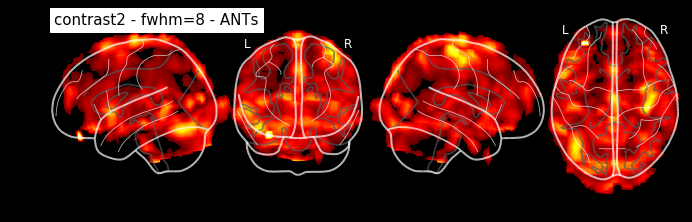

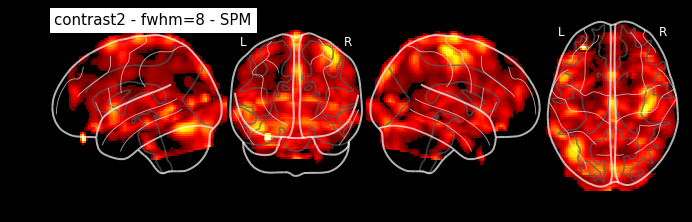

In [21]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(
    '/output/datasink/norm_ants/sub-01_fwhm8/con_0002_trans.nii',
    threshold=1, display_mode='lyrz', black_bg=True, vmax=8, title='contrast2 - fwhm=8 - ANTs')
plot_glass_brain(
    '/output/datasink/norm_spm/sub-01_fwhm8/wcon_0002.nii',
    threshold=1, display_mode='lyrz', black_bg=True, vmax=8, title='contrast2 - fwhm=8 - SPM')